# **Predicting Monthly Software Vulnerability (CVE) Disclosure Trends for 2024**
### A Time Series (SARIMAX) Approach


# **Data Ingestion**

In [48]:
# Download and extract CVE data from NVD Data from 2018 till 2023
%%capture
!mkdir -p jsondata
%cd jsondata
!rm *.json
!rm *.zip
!wget https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{2018..2023}.json.zip
!unzip -o "*.zip"

In [2]:
# Importing necessary libraries for data analysis and time series modeling

import glob  # Module for finding pathnames matching a specified pattern according to the rules used by the Unix shell
import json  # Module for working with JSON data
import pandas as pd  # Data manipulation and analysis library
import numpy as np  # Numerical computing library

# Time series analysis libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model
from sklearn.model_selection import ParameterGrid  # Class for generating all possible combinations of hyperparameters
from statsmodels.tsa.stattools import acf  # Autocorrelation function
from statsmodels.tsa.seasonal import seasonal_decompose  # Decomposition of time series into trend, seasonal, and residual components

# Data visualization libraries
import matplotlib.pyplot as plt  # 2D plotting library
import seaborn as sns  # Statistical data visualization based on matplotlib
import matplotlib.ticker as ticker  # Locator and formatter classes for tick locations and labels
import plotly.express as px  # High-level interface for creating expressive and interactive plots
from plotly.subplots import make_subplots  # Module for creating subplots in Plotly
from matplotlib.dates import date2num  # Conversion of date to numeric format for plotting

# Model evaluation metrics
from sklearn.metrics import mean_squared_error

In [3]:
# Extract and process data
row_accumulator = []
for filename in glob.glob('nvdcve-1.1-*.json'):
  with open(filename, 'r', encoding='utf-8') as f:
    nvd_data = json.load(f)
    for entry in nvd_data['CVE_Items']:
      cve = entry['cve']['CVE_data_meta']['ID']
      published_date = entry.get('publishedDate', 'Missing_Data')
      description = entry.get('cve', {}).get('description', {}).get('description_data', [{}])[0].get('value', '')
      new_row = {
          'CVE': cve,
          'Published': published_date,
          'Description': description,
          }
      if not description.startswith('Reject'):
            row_accumulator.append(new_row)

# Create DataFrame
nvd = pd.DataFrame(row_accumulator)

# **Examine and Prepare the Data**

In [4]:
# Convert 'Published' column to datetime
nvd['Published'] = pd.to_datetime(nvd['Published'])
nvd['Published'] = pd.to_datetime(nvd['Published']).apply(lambda x: x.date())
nvd['Published'] = pd.to_datetime(nvd['Published'], errors='coerce')

In [5]:
# Confirm the Data Types
nvd.dtypes

CVE                    object
Published      datetime64[ns]
Description            object
dtype: object

In [6]:
# Define the date range and Filter the data for the required period (2018 - 2023)
start_date = '2018-01-01'
end_date = '2023-12-31'

# Filter the data
nvd = nvd[(nvd['Published'] >= start_date) & (nvd['Published'] <= end_date)]

In [7]:
#Confirm the Data Range Selection
oldest_date = nvd['Published'].min()
newest_date = nvd['Published'].max()
print(f'Oldest date: {oldest_date}')
print(f'Newest date: {newest_date}')

Oldest date: 2018-01-01 00:00:00
Newest date: 2023-12-31 00:00:00


In [8]:
#Review the Dataframe
print(nvd.head())

             CVE  Published                                        Description
0  CVE-2021-0001 2021-06-09  Observable timing discrepancy in Intel(R) IPP ...
1  CVE-2021-0002 2021-08-11  Improper conditions check in some Intel(R) Eth...
2  CVE-2021-0003 2021-08-11  Improper conditions check in some Intel(R) Eth...
3  CVE-2021-0004 2021-08-11  Improper buffer restrictions in the firmware o...
4  CVE-2021-0005 2021-08-11  Uncaught exception in firmware for Intel(R) Et...


In [9]:
# Find the number of rows that contain 'Reject' to ensure rejected records were excluded
num_reject = nvd[nvd['Description'].str.contains('Reject')].shape[0]
print(f"Number of rows that contain 'Reject': {num_reject}")

Number of rows that contain 'Reject': 10


In [10]:
# Print the rows that contain 'Reject' to examine the Description
print(nvd[nvd['Description'].str.contains('Reject')])

                     CVE  Published  \
2849      CVE-2021-21299 2021-02-11   
29414     CVE-2022-27182 2022-05-05   
36282     CVE-2022-36046 2022-08-31   
83465     CVE-2023-22422 2023-02-01   
95424     CVE-2023-39532 2023-08-08   
103932  CVE-2019-1003024 2019-02-20   
104703    CVE-2019-10552 2020-03-05   
104704    CVE-2019-10553 2020-03-05   
104705    CVE-2019-10554 2020-03-05   
113109     CVE-2019-2335 2019-11-21   

                                              Description  
2849    hyper is an open-source HTTP library for Rust ...  
29414   On F5 BIG-IP 16.1.x versions prior to 16.1.2.2...  
36282   Next.js is a React framework that can provide ...  
83465   On BIG-IP versions 17.0.x before 17.0.0.2 and ...  
95424   SES is a JavaScript environment that allows sa...  
103932  A sandbox bypass vulnerability exists in Jenki...  
104703  Multiple Buffer Over-read issue can happen due...  
104704  Multiple Read overflows due to improper length...  
104705  Multiple Read overflow

The above rows contain the keyword reject but are not CVEs with Rejected status.

# **Prepare the Time Series Data Frame**

In [11]:
# Create a New Data Frame - Aggregated Counts by Month
monthly_cves = (
    nvd.groupby(nvd['Published'].dt.to_period("M"))
       .size()
       .reset_index(name='Count')
       .rename(columns={'Published': 'Month'})
)

In [12]:
# Display the resulting DataFrame
print(monthly_cves.head())

     Month  Count
0  2018-01    647
1  2018-02    677
2  2018-03    870
3  2018-04    968
4  2018-05    944


In [13]:
# Examine the distribution of the Time Series Format
monthly_cves['Count'].describe()

count      72.000000
mean     1643.666667
std       513.270815
min       647.000000
25%      1218.500000
50%      1568.000000
75%      2043.500000
max      2669.000000
Name: Count, dtype: float64

# **Visualize the Distribution**

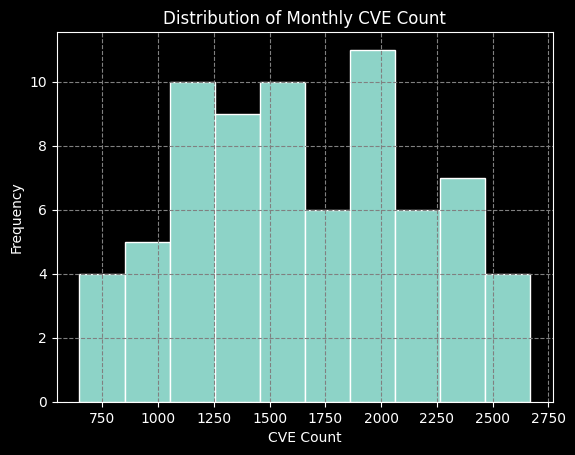

In [14]:
# Set dark mode for the plot
plt.style.use('dark_background')

# Create the distribution plot
plt.hist(monthly_cves['Count'], bins=10, edgecolor="white")  # Adjust the number of bins as needed

# Customize plot elements for better visibility in dark mode
plt.xlabel("CVE Count", color="white")
plt.ylabel("Frequency", color="white")
plt.title("Distribution of Monthly CVE Count", color="white")
plt.grid(color="gray", linestyle="--")

# Display the plot
plt.show()

# **Plot the Time Series Data on a Line Chart**

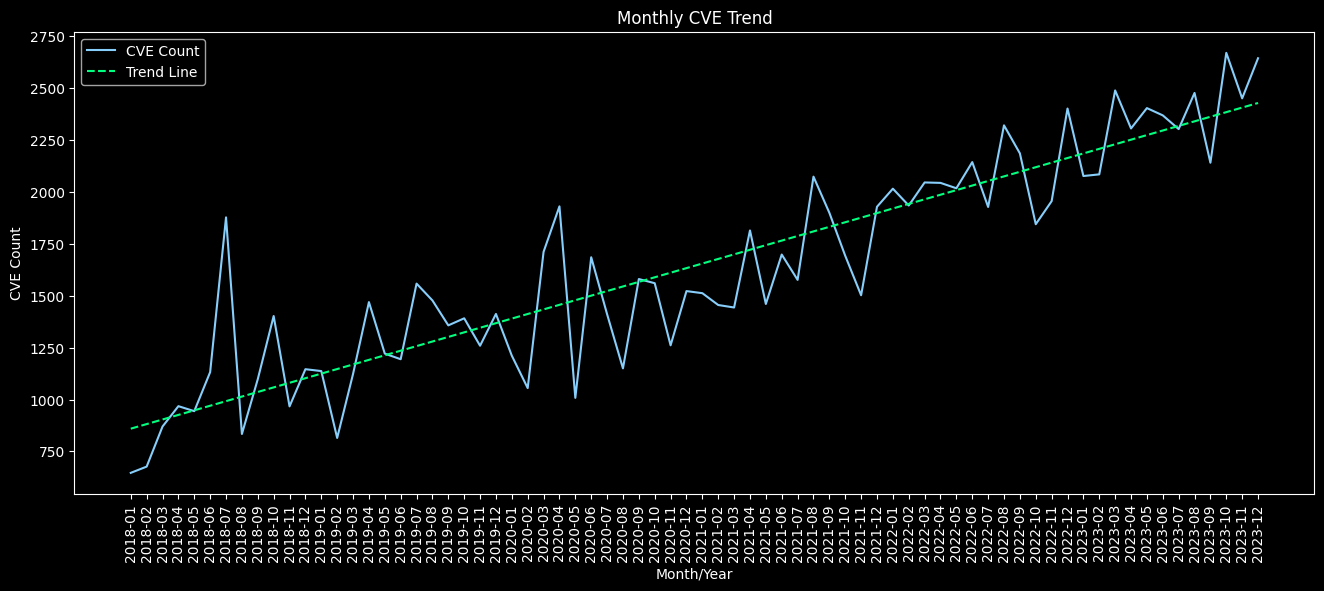

In [15]:
# Use dark background style
plt.style.use('dark_background')

# Visualizing Time Series data
plt.figure(figsize=(16, 6))

# Plotting the CVE counts
plt.plot(monthly_cves['Month'].astype(str), monthly_cves['Count'], color='lightskyblue', label='CVE Count')

# Adding a dotted trend line
trend_line = np.polyfit(np.arange(len(monthly_cves)), monthly_cves['Count'], 1)
plt.plot(monthly_cves['Month'].astype(str), np.polyval(trend_line, np.arange(len(monthly_cves))), linestyle='--', color='springgreen', label='Trend Line')

plt.xlabel('Month/Year')
plt.ylabel('CVE Count')
plt.title('Monthly CVE Trend')

# Rotate x-labels vertically and set font size
plt.xticks(rotation='vertical', fontsize=10)

plt.legend()
plt.show()

The next steps are performed to prepare the data to plot the Polar Chats with Subplots for each year.

In [16]:
# Examine the Data Times in the New Data Frame
monthly_cves.dtypes

Month    period[M]
Count        int64
dtype: object

In [17]:
# Convert 'Month' column to datetime format
monthly_cves['Month'] = monthly_cves['Month'].astype('datetime64[ns]')

In [18]:
monthly_cves.dtypes

Month    datetime64[ns]
Count             int64
dtype: object

In [19]:
# Extract month and year from Month column
monthly_cves["Month_num"] = monthly_cves["Month"].dt.month
monthly_cves["Year"] = monthly_cves["Month"].dt.year

In [20]:
# Adding a new column 'Month_Name' to the DataFrame 'monthly_cves'
# Mapping the numerical month values to their corresponding three-letter month abbreviations
monthly_cves['Month_Name'] = monthly_cves['Month_num'].map({
    1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr",
    5: "May", 6: "Jun", 7: "Jul", 8: "Aug",
    9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"
})

In [21]:
# Sort the Dataframe by Month
monthly_cves = monthly_cves.sort_values(by='Month')

In [22]:
# Review the Dataframe
monthly_cves.head()

,Month,Count,Month_num,Year,Month_Name
0,2018-01-01,647,1,2018,Jan
1,2018-02-01,677,2,2018,Feb
2,2018-03-01,870,3,2018,Mar
3,2018-04-01,968,4,2018,Apr
4,2018-05-01,944,5,2018,May


In [23]:
# Create a List of unique years in the DataFrame
years = [2018,2019,2020,2021,2022,2023]

In [24]:
  month_angle_map = {
    "Jan": 0,
    "Feb": 330,
    "Mar": 300,
    "Apr": 270,
    "May": 240,
    "Jun": 210,
    "Jul": 180,
    "Aug": 150,
    "Sep": 120,
    "Oct": 90,
    "Nov": 60,
    "Dec": 30,
    }

# **Generate a Polar Plot with Yearly Subplots**

In [25]:
# Create a 2x3 subplot grid with adjusted title padding
fig = make_subplots(
    rows=2, cols=3, subplot_titles=[f"{year}" for year in years],
    specs=[[{'type': 'polar'} for _ in range(3)]]*2,
    vertical_spacing=0.02
)
year_colors = ['lightgreen', 'orange', 'coral', 'turquoise', 'red', 'magenta']

# Loop through each year and add a subplot
for i, year in enumerate(years, start=1):
  # Define custom color list
  data_year = monthly_cves[monthly_cves['Year'] == year]
  # Map month names to specific theta angles
  data_year['Theta'] = data_year['Month_Name'].map(month_angle_map)
  current_color = [year_colors[i-1]]
  subplot = px.line_polar(
      data_year,
      r="Count",
      theta="Theta",
      line_close=True,
      color="Year",
      color_discrete_sequence=current_color,
      template="plotly_dark",
      direction="clockwise",
      width = 600,
      height = 600,
      markers=True,
      )
   # Add subplot to the main figure
  fig.add_trace(subplot['data'][0], row=int((i - 1) / 3) + 1, col=(i % 3) + 1)

  # Update main figure layout
  fig.update_layout(
    showlegend=False,
    title_text="<b>CVEs Published by Month</b><br><span style='font-size: 0.7em;'>Polar plot to explore Seasonality and Dominant Months. Notice the variance in scales by Year. </span>",
    template="plotly_dark",
    title_x=0.5,
    margin=dict(b=20, t = 140),
    width = 1010,
    height = 1000,
  )

# Update polar subplot layout
fig.update_polars(
    radialaxis=dict(
        visible=True,
        tickangle=270,
        showline=True,
    ),
    angularaxis=dict(
        visible=True,
        tickvals=[v for k, v in month_angle_map.items()],
        ticktext=list(month_angle_map.keys()),
        tickmode='array',
        tickangle=0,
        showline=True,
    )
)

# Show the combined subplot
fig.show()

<ipython-input-25-9528fbbd7d75>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-25-9528fbbd7d75>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-25-9528fbbd7d75>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-25-9528

# **Generate the ACF Plot**

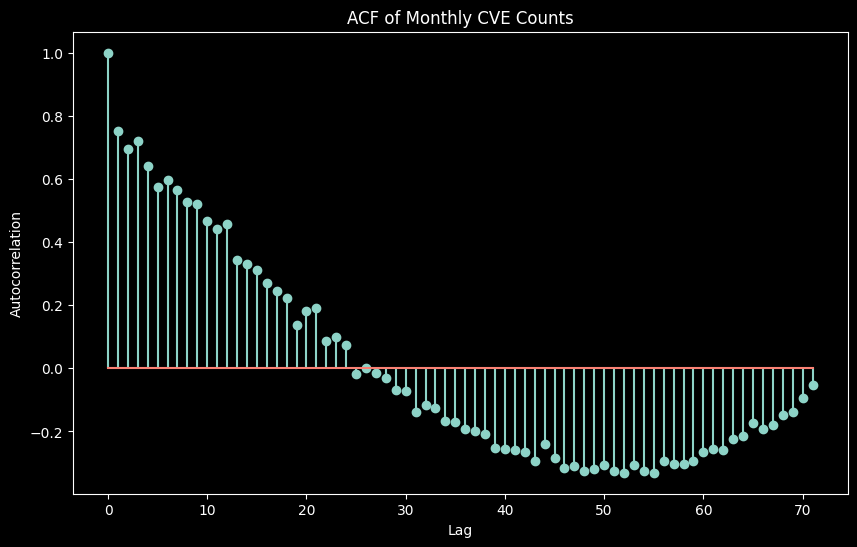

In [26]:
# Use dark background style
plt.style.use('dark_background')

# Calculate ACF
acf_values = acf(monthly_cves['Count'], nlags=72)  # Adjust nlags based on your data frequency

# Plot ACF
plt.figure(figsize=(10, 6))
plt.stem(acf_values)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of Monthly CVE Counts')
plt.show()

# **Generate the Seasonal Decompostion Plot**

In [27]:
# Seasonal decomposition
decomposition = seasonal_decompose(monthly_cves["Count"], model="multiplicative", period=12)

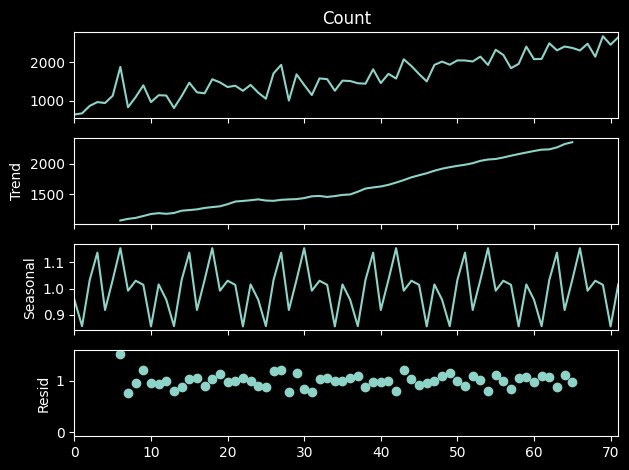

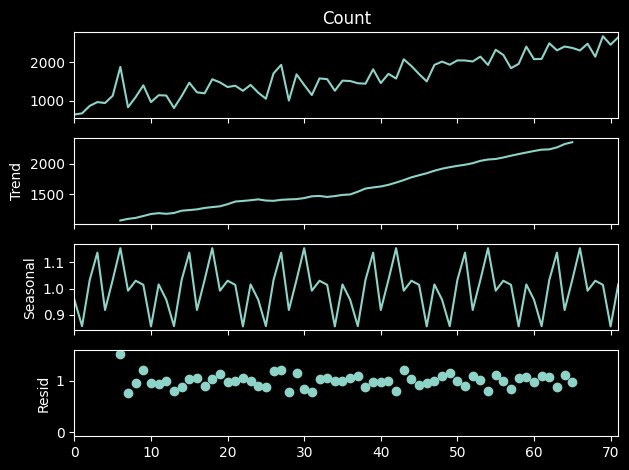

In [28]:
# Use dark background style
plt.style.use('dark_background')
decomposition.plot()

# **Prepare the Data for SARIMAX Model and Evaluation**

In [29]:
# Define the number of months for training, test, and future predictions
train_months = 60
test_months = 12
future_months = 12

In [30]:
# Extract the training data
train_data = monthly_cves.head(train_months)

In [31]:
# Extract the test data
test_data = monthly_cves.iloc[train_months: train_months + test_months]

In [32]:
# Initialize variables for best model and metrics
best_params = None
best_rmse = np.inf
best_model = None

In [33]:
# Create a Parameter Grid
param_grid = {
    'order': [(2, 1, 1), (3, 1, 2), (2, 2, 2), (3, 1, 3)],
    'seasonal_order': [(1, 1, 1, 12), (1, 1, 2, 12), (2, 1, 2, 12), (1, 1, 1, 12)],
    'trend': ['n', 'c', 't', 'ct'],
    'enforce_stationarity': [True, False],
    'enforce_invertibility': [True, False],
}

In [34]:
# Perform hyperparameter tuning
for params in ParameterGrid(param_grid):
    model = SARIMAX(train_data['Count'], **params)
    model_fit = model.fit(method='powell', maxiter=5000)

    # Predictions for the test set
    predictions_test = model_fit.predict(start=test_data.index[0], end=test_data.index[-1])

    # Calculate metrics for the test set
    actual_values_test = test_data['Count']
    rmse_test = np.sqrt(mean_squared_error(actual_values_test, predictions_test))

    # Check if the current model has lower metrics
    if rmse_test < best_rmse:
      best_rmse = rmse_test
      best_model = model_fit

# Print the best hyperparameters and metrics
print("Best Hyperparameters:", best_model.model_orders)
print(f"Best RMSE for the test set: {best_rmse:.2f}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.430385
         Iterations: 4
         Function evaluations: 264


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.429644
         Iterations: 4
         Function evaluations: 294


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.427073
         Iterations: 4
         Function evaluations: 298


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.400756
         Iterations: 7
         Function evaluations: 580


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.429867
         Iterations: 5
         Function evaluations: 379


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.429193
         Iterations: 5
         Function evaluations: 420


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.426851
         Iterations: 5
         Function evaluations: 419


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.401983
         Iterations: 8
         Function evaluations: 731


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.429967
         Iterations: 4
         Function evaluations: 340


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.429033
         Iterations: 5
         Function evaluations: 467


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.426666
         Iterations: 5
         Function evaluations: 472


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.403270
         Iterations: 8
         Function evaluations: 823


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.430385
         Iterations: 4
         Function evaluations: 264


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.429644
         Iterations: 4
         Function evaluations: 294


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.427073
         Iterations: 4
         Function evaluations: 298


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.400756
         Iterations: 7
         Function evaluations: 580


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.427473
         Iterations: 4
         Function evaluations: 337


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.426276
         Iterations: 4
         Function evaluations: 374


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.422915
         Iterations: 5
         Function evaluations: 468


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.401162
         Iterations: 8
         Function evaluations: 821


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.426923
         Iterations: 5
         Function evaluations: 484


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.425774
         Iterations: 5
         Function evaluations: 530


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.422956
         Iterations: 5
         Function evaluations: 519


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.395375
         Iterations: 11
         Function evaluations: 1264


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.426549
         Iterations: 5
         Function evaluations: 535


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.425523
         Iterations: 5
         Function evaluations: 577


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.422438
         Iterations: 5
         Function evaluations: 578


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.394809
         Iterations: 9
         Function evaluations: 1192


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.427473
         Iterations: 4
         Function evaluations: 337


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.426276
         Iterations: 4
         Function evaluations: 374


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.422915
         Iterations: 5
         Function evaluations: 468


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.401162
         Iterations: 8
         Function evaluations: 821


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.372807
         Iterations: 6
         Function evaluations: 465


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.361787
         Iterations: 6
         Function evaluations: 516


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.365799
         Iterations: 5
         Function evaluations: 428


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.338432
         Iterations: 10
         Function evaluations: 949


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.372462
         Iterations: 6
         Function evaluations: 542


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.361993
         Iterations: 6
         Function evaluations: 598


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.365514
         Iterations: 6
         Function evaluations: 587


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.333211
         Iterations: 11
         Function evaluations: 1191


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.370142
         Iterations: 5
         Function evaluations: 501


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.359184
         Iterations: 6
         Function evaluations: 634


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.363381
         Iterations: 6
         Function evaluations: 643


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.352050
         Iterations: 10
         Function evaluations: 1200


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.372807
         Iterations: 6
         Function evaluations: 465


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.361787
         Iterations: 6
         Function evaluations: 516


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.365799
         Iterations: 5
         Function evaluations: 428


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.338432
         Iterations: 10
         Function evaluations: 949


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.407884
         Iterations: 3
         Function evaluations: 294


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.397435
         Iterations: 5
         Function evaluations: 530


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.390037
         Iterations: 6
         Function evaluations: 638


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.373666
         Iterations: 5
         Function evaluations: 566


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.407299
         Iterations: 3
         Function evaluations: 316


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.397747
         Iterations: 4
         Function evaluations: 470


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.390908
         Iterations: 6
         Function evaluations: 693


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.370574
         Iterations: 7
         Function evaluations: 868


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.407923
         Iterations: 2
         Function evaluations: 228


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.397550
         Iterations: 5
         Function evaluations: 633


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.390385
         Iterations: 5
         Function evaluations: 623


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.370851
         Iterations: 7
         Function evaluations: 954


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.407884
         Iterations: 3
         Function evaluations: 294


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.397435
         Iterations: 5
         Function evaluations: 530


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.390037
         Iterations: 6
         Function evaluations: 638


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.373666
         Iterations: 5
         Function evaluations: 566


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.808959
         Iterations: 5
         Function evaluations: 300


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.807596
         Iterations: 5
         Function evaluations: 346


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.805531
         Iterations: 5
         Function evaluations: 344


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.798951
         Iterations: 5
         Function evaluations: 384


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.324003
         Iterations: 6
         Function evaluations: 429


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.316359
         Iterations: 6
         Function evaluations: 478


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.307096
         Iterations: 9
         Function evaluations: 761


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.322167
         Iterations: 6
         Function evaluations: 526


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.308442
         Iterations: 6
         Function evaluations: 495


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.267411
         Iterations: 9
         Function evaluations: 835


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.280551
         Iterations: 11
         Function evaluations: 1049


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.245404
         Iterations: 15
         Function evaluations: 1520


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.808959
         Iterations: 5
         Function evaluations: 300


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.807596
         Iterations: 5
         Function evaluations: 346


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.805531
         Iterations: 5
         Function evaluations: 344


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.798951
         Iterations: 5
         Function evaluations: 384


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.745012
         Iterations: 13
         Function evaluations: 1153


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.745006
         Iterations: 13
         Function evaluations: 1274


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.744762
         Iterations: 13
         Function evaluations: 1229


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.741653
         Iterations: 13
         Function evaluations: 1423


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.198341
         Iterations: 16
         Function evaluations: 1397


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.198184
         Iterations: 19
         Function evaluations: 1859


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.198305
         Iterations: 18
         Function evaluations: 1741


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.197424
         Iterations: 18
         Function evaluations: 1891


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.187867
         Iterations: 19
         Function evaluations: 1860


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.187789
         Iterations: 23
         Function evaluations: 2475


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.187407
         Iterations: 17
         Function evaluations: 1851


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.184642
         Iterations: 20
         Function evaluations: 2274


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.745012
         Iterations: 13
         Function evaluations: 1153


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.745006
         Iterations: 13
         Function evaluations: 1274


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.744762
         Iterations: 13
         Function evaluations: 1229


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.741653
         Iterations: 13
         Function evaluations: 1423


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.577580
         Iterations: 7
         Function evaluations: 542


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.574601
         Iterations: 6
         Function evaluations: 564


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.575512
         Iterations: 6
         Function evaluations: 543


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.546992
         Iterations: 14
         Function evaluations: 1418


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.104555
         Iterations: 12
         Function evaluations: 994


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.101152
         Iterations: 9
         Function evaluations: 836


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.102511
         Iterations: 11
         Function evaluations: 1000


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.096070
         Iterations: 15
         Function evaluations: 1485


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.108441
         Iterations: 5
         Function evaluations: 550


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.106808
         Iterations: 6
         Function evaluations: 703


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.054882
         Iterations: 10
         Function evaluations: 1084


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.109747
         Iterations: 6
         Function evaluations: 744


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.577580
         Iterations: 7
         Function evaluations: 542


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.574601
         Iterations: 6
         Function evaluations: 564


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.575512
         Iterations: 6
         Function evaluations: 543


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.546992
         Iterations: 14
         Function evaluations: 1418


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.536336
         Iterations: 2
         Function evaluations: 182


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.525092
         Iterations: 5
         Function evaluations: 500


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.520380
         Iterations: 7
         Function evaluations: 705


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.499071
         Iterations: 10
         Function evaluations: 1125


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.066625
         Iterations: 19
         Function evaluations: 2022


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.041926
         Iterations: 8
         Function evaluations: 925


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.046464
         Iterations: 8
         Function evaluations: 929


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.040879
         Iterations: 15
         Function evaluations: 1894


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.064749
         Iterations: 17
         Function evaluations: 1986


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.059788
         Iterations: 10
         Function evaluations: 1287


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 1.991980
         Iterations: 20
         Function evaluations: 2386


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.042297
         Iterations: 20
         Function evaluations: 2627


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.536336
         Iterations: 2
         Function evaluations: 182


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.525092
         Iterations: 5
         Function evaluations: 500


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.520380
         Iterations: 7
         Function evaluations: 705


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 3.499071
         Iterations: 10
         Function evaluations: 1125
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 3
         Function evaluations: 274
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 2
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 5.427134
         Iterations: 10
         Function evaluations: 1173
Optimization terminated successfully.
         Current function value: 5.400168
         Iterations: 10
         Function evaluations: 1275


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.429902
         Iterations: 5
         Function evaluations: 376


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.429232
         Iterations: 5
         Function evaluations: 414


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.426874
         Iterations: 5
         Function evaluations: 413


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.397835
         Iterations: 6
         Function evaluations: 557


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.429793
         Iterations: 4
         Function evaluations: 341


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.429077
         Iterations: 5
         Function evaluations: 469


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.426684
         Iterations: 5
         Function evaluations: 472


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.397160
         Iterations: 7
         Function evaluations: 742
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 3
         Function evaluations: 274
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 2
         Function evaluations: 153
Optimization terminated successfully.
         Current function value: 5.427134
         Iterations: 10
         Function evaluations: 1173
Optimization terminated successfully.
         Current function value: 5.400168
         Iterations: 10
         Function evaluations: 1275


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.429731
         Iterations: 8
         Function evaluations: 959


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.429712
         Iterations: 10
         Function evaluations: 1288


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.427195
         Iterations: 9
         Function evaluations: 1141


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.393909
         Iterations: 14
         Function evaluations: 1950


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.435132
         Iterations: 4
         Function evaluations: 406


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.434768
         Iterations: 4
         Function evaluations: 444


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.417761
         Iterations: 7
         Function evaluations: 744


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.392023
         Iterations: 11
         Function evaluations: 1330


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.435131
         Iterations: 4
         Function evaluations: 446


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.434813
         Iterations: 4
         Function evaluations: 480


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.417198
         Iterations: 7
         Function evaluations: 809


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.393418
         Iterations: 12
         Function evaluations: 1610


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.429731
         Iterations: 8
         Function evaluations: 959


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.429712
         Iterations: 10
         Function evaluations: 1288


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.427195
         Iterations: 9
         Function evaluations: 1141


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



Optimization terminated successfully.
         Current function value: 5.393909
         Iterations: 14
         Function evaluations: 1950
Optimization terminated successfully.
         Current function value: 5.373125
         Iterations: 10
         Function evaluations: 1113
Optimization terminated successfully.
         Current function value: 5.361527
         Iterations: 10
         Function evaluations: 1151
Optimization terminated successfully.
         Current function value: 5.365359
         Iterations: 10
         Function evaluations: 1205
Optimization terminated successfully.
         Current function value: 5.352587
         Iterations: 12
         Function evaluations: 1501


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.372288
         Iterations: 7
         Function evaluations: 616


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.361709
         Iterations: 8
         Function evaluations: 782


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.365374
         Iterations: 7
         Function evaluations: 681


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.337951
         Iterations: 12
         Function evaluations: 1353


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.370136
         Iterations: 8
         Function evaluations: 805


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.366626
         Iterations: 9
         Function evaluations: 965


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.368231
         Iterations: 9
         Function evaluations: 961


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.340721
         Iterations: 10
         Function evaluations: 1181
Optimization terminated successfully.
         Current function value: 5.373125
         Iterations: 10
         Function evaluations: 1113
Optimization terminated successfully.
         Current function value: 5.361527
         Iterations: 10
         Function evaluations: 1151
Optimization terminated successfully.
         Current function value: 5.365359
         Iterations: 10
         Function evaluations: 1205
Optimization terminated successfully.
         Current function value: 5.352587
         Iterations: 12
         Function evaluations: 1501
Optimization terminated successfully.
         Current function value: 5.404565
         Iterations: 10
         Function evaluations: 1302
Optimization terminated successfully.
         Current function value: 5.396310
         Iterations: 12
         Function evaluations: 1641
Optimization termina

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.405778
         Iterations: 4
         Function evaluations: 426


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.397301
         Iterations: 4
         Function evaluations: 459


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.389232
         Iterations: 5
         Function evaluations: 581


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.371928
         Iterations: 6
         Function evaluations: 752


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.405168
         Iterations: 4
         Function evaluations: 467


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.396747
         Iterations: 5
         Function evaluations: 632


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.388794
         Iterations: 5
         Function evaluations: 627


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 5.372701
         Iterations: 5
         Function evaluations: 691
Optimization terminated successfully.
         Current function value: 5.404565
         Iterations: 10
         Function evaluations: 1302
Optimization terminated successfully.
         Current function value: 5.396310
         Iterations: 12
         Function evaluations: 1641
Optimization terminated successfully.
         Current function value: 5.389219
         Iterations: 10
         Function evaluations: 1355
Optimization terminated successfully.
         Current function value: 5.371355
         Iterations: 11
         Function evaluations: 1506
Optimization terminated successfully.
         Current function value: 3.304089
         Iterations: 4
         Function evaluations: 719
Optimization terminated successfully.
         Current function value: 6.516151
         Iterations: 2
         Function evaluations: 378
Optimization terminated su

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.323953
         Iterations: 6
         Function evaluations: 432


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.310301
         Iterations: 9
         Function evaluations: 727


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.307106
         Iterations: 9
         Function evaluations: 748


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.321916
         Iterations: 6
         Function evaluations: 530


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.308262
         Iterations: 6
         Function evaluations: 493


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.265250
         Iterations: 7
         Function evaluations: 643


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.276196
         Iterations: 7
         Function evaluations: 651


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.283228
         Iterations: 12
         Function evaluations: 1199
Optimization terminated successfully.
         Current function value: 3.304089
         Iterations: 4
         Function evaluations: 719
Optimization terminated successfully.
         Current function value: 6.516151
         Iterations: 2
         Function evaluations: 378
Optimization terminated successfully.
         Current function value: 15.677708
         Iterations: 3
         Function evaluations: 688
Optimization terminated successfully.
         Current function value: 1.263144
         Iterations: 2
         Function evaluations: 506
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 59
Optimization terminated success

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.272384
         Iterations: 23
         Function evaluations: 2200


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.157180
         Iterations: 18
         Function evaluations: 1834


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.193581
         Iterations: 16
         Function evaluations: 1653


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.190625
         Iterations: 20
         Function evaluations: 2242


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.233396
         Iterations: 21
         Function evaluations: 2235


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.152981
         Iterations: 16
         Function evaluations: 1878


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.213360
         Iterations: 29
         Function evaluations: 3241


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.192837
         Iterations: 17
         Function evaluations: 2109
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 65
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 59
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 1
         Function evaluations: 60
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 2
         Function evaluations: 218
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 3
         Function evaluations: 688
Optimization terminated successfully.
         Current function value: 16.331965
         Iterations: 3
         Function evaluations: 940
Optimization terminated succe

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.105486
         Iterations: 11
         Function evaluations: 919


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.100906
         Iterations: 12
         Function evaluations: 1102


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.102034
         Iterations: 11
         Function evaluations: 1014


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.096015
         Iterations: 18
         Function evaluations: 1740


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.107705
         Iterations: 5
         Function evaluations: 482


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.106330
         Iterations: 6
         Function evaluations: 622


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.106268
         Iterations: 6
         Function evaluations: 623


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.109159
         Iterations: 5
         Function evaluations: 561
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 3
         Function evaluations: 688
Optimization terminated successfully.
         Current function value: 16.331965
         Iterations: 3
         Function evaluations: 940
Optimization terminated successfully.
         Current function value: 8.134588
         Iterations: 3
         Function evaluations: 784
Optimization terminated successfully.
         Current function value: 2.612946
         Iterations: 6
         Function evaluations: 1797
Optimization terminated successfully.
         Current function value: 0.669647
         Iterations: 3
         Function evaluations: 1028
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 2
         Function evaluations: 302
Optimization terminated succe

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.079488
         Iterations: 14
         Function evaluations: 1423


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.046032
         Iterations: 9
         Function evaluations: 1007


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.049407
         Iterations: 9
         Function evaluations: 994


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.057256
         Iterations: 14
         Function evaluations: 1711


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.052242
         Iterations: 24
         Function evaluations: 2741


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.045997
         Iterations: 10
         Function evaluations: 1215


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.046571
         Iterations: 14
         Function evaluations: 1714


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



Optimization terminated successfully.
         Current function value: 2.043335
         Iterations: 21
         Function evaluations: 2887
Optimization terminated successfully.
         Current function value: 0.669647
         Iterations: 3
         Function evaluations: 1028
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 2
         Function evaluations: 302
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 3
         Function evaluations: 1057
Optimization terminated successfully.
         Current function value: -0.000000
         Iterations: 3
         Function evaluations: 552
Best Hyperparameters: {'trend': 0, 'exog': 0, 'ar': 3, 'ma': 2, 'seasonal_ar': 12, 'seasonal_ma': 24, 'reduced_ar': 15, 'reduced_ma': 26, 'exog_variance': 0, 'measurement_variance': 0, 'variance': 1}
Best RMSE for the test set: 188.63


In [35]:
best_model.model_orders

{'trend': 0,
 'exog': 0,
 'ar': 3,
 'ma': 2,
 'seasonal_ar': 12,
 'seasonal_ma': 24,
 'reduced_ar': 15,
 'reduced_ma': 26,
 'exog_variance': 0,
 'measurement_variance': 0,
 'variance': 1}

In [36]:
best_rmse

188.63233127063208

# **Generate Predictions Using the Best Model Hyperparameters**

In [37]:
# Predictions for the test set using the best model
predictions_test = best_model.predict(start=test_data.index[0], end=test_data.index[-1])

In [38]:
# Find the last date in the dataset
last_date = monthly_cves['Month'].max()

In [39]:
# Find the first day of the next month
next_month_first_day = last_date + pd.DateOffset(months=1)
next_month_first_day = next_month_first_day.replace(day=1)

In [40]:
# Predictions for the future (next 12 months) using the best model
future_index = pd.date_range(start=next_month_first_day, periods=future_months, freq='MS')

In [41]:
future_predictions = best_model.get_forecast(steps=future_months).predicted_mean

In [42]:
future_predictions

60    2217.182890
61    2187.230036
62    2520.445734
63    2520.092855
64    2324.052012
65    2557.385611
66    2361.231940
67    2549.566833
68    2551.744659
69    2321.669290
70    2362.820043
71    2659.921546
Name: predicted_mean, dtype: float64

In [43]:
# Create a DataFrame for future predictions with the correct index
future_predictions_df = pd.DataFrame(data={'Month': future_index, 'Count': future_predictions.values}, index=range(72, 72 + future_months))

In [44]:
# Print the Future Predictions
future_predictions_df

,Month,Count
72,2024-01-01,2217.182890
73,2024-02-01,2187.230036
74,2024-03-01,2520.445734
75,2024-04-01,2520.092855
76,2024-05-01,2324.052012
77,2024-06-01,2557.385611
78,2024-07-01,2361.231940
79,2024-08-01,2549.566833
80,2024-09-01,2551.744659
81,2024-10-01,2321.669290


# **Plot the Complete Data Trend, Including the generated predictions**

In [45]:
# Extract 'Month' and 'Count' columns for training and test data
train_data_subset = train_data[['Month', 'Count']]
test_data_subset = test_data[['Month', 'Count']]

In [46]:
# Concatenate training, test, and future predictions DataFrames
consolidated_data = pd.concat([train_data_subset, test_data_subset, future_predictions_df])

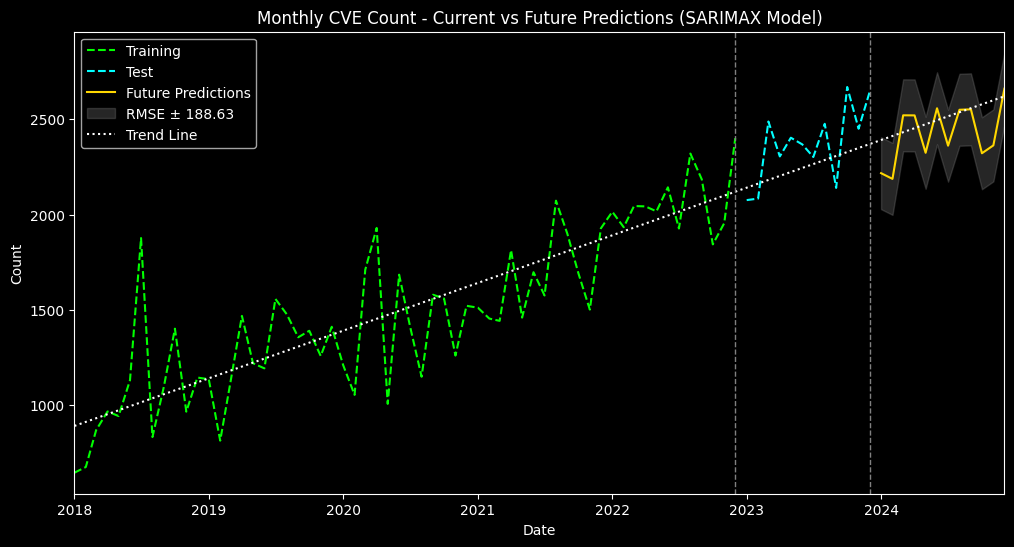

In [47]:
# Use dark background style
plt.style.use('dark_background')

# Plot entire data with labels, color differences, and a trend line
plt.figure(figsize=(12, 6))

# Plot Training data
plt.plot(train_data_subset['Month'], train_data_subset['Count'], label='Training', color='lime', linestyle='--')

# Plot Test data
plt.plot(test_data_subset['Month'], test_data_subset['Count'], label='Test', color='cyan', linestyle='--')

# Plot Future Predictions
plt.plot(future_predictions_df['Month'], future_predictions_df['Count'], label='Future Predictions', color='gold')

# Highlight the MAPE error band for the future predictions
mape_upper = future_predictions_df['Count'] + best_rmse
mape_lower = future_predictions_df['Count'] - best_rmse
plt.fill_between(future_predictions_df['Month'], mape_lower, mape_upper, color='gray', alpha=0.3, label=f'RMSE ± {best_rmse:.2f}')

# Convert 'Month' column to numerical values
consolidated_data['NumericalMonth'] = date2num(consolidated_data['Month'])

# Plot the trend line for the entire data
trend_line = np.polyfit(consolidated_data['NumericalMonth'], consolidated_data['Count'], 1)
plt.plot(consolidated_data['Month'], np.polyval(trend_line, consolidated_data['NumericalMonth']), linestyle=':', color='white', label='Trend Line')

# Drop the temporary column
consolidated_data.drop('NumericalMonth', axis=1, inplace=True)

# Add vertical lines between training, test, and future bands
plt.axvline(train_data_subset['Month'].max(), color='grey', linestyle='--', linewidth=1)
plt.axvline(test_data_subset['Month'].max(), color='grey', linestyle='--', linewidth=1)


plt.title('Monthly CVE Count - Current vs Future Predictions (SARIMAX Model)')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()

# Set x-axis limits based on the data
plt.xlim([monthly_cves['Month'].min(), future_predictions_df['Month'].max()])

plt.show()